<a href="https://colab.research.google.com/github/Tim-Li/X-ray_summer_school_2022/blob/main/code/Python%E5%AF%A6%E4%BD%9C_Day2%EF%BC%9A%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92%E5%9C%A8%E4%B8%89%E7%B6%ADX%E5%85%89%E5%BD%B1%E5%83%8F%E6%87%89%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python實作 Day2：深度學習在三維X光影像應用

# 操作說明

## X光影像分割流程

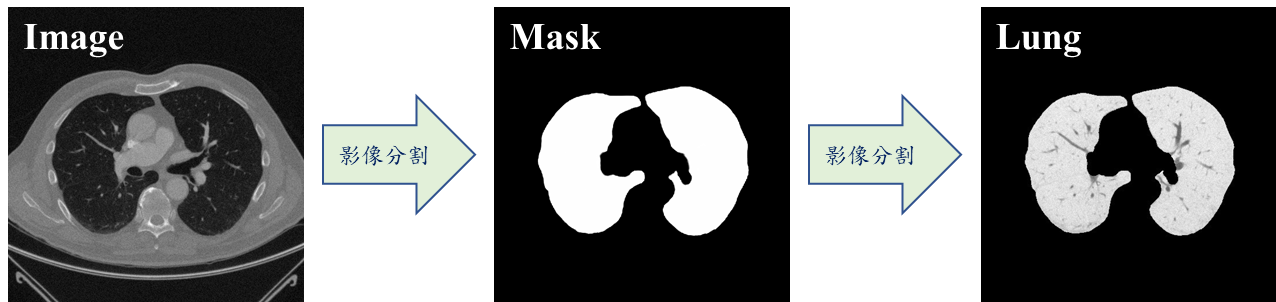

### 1️⃣模型訓練

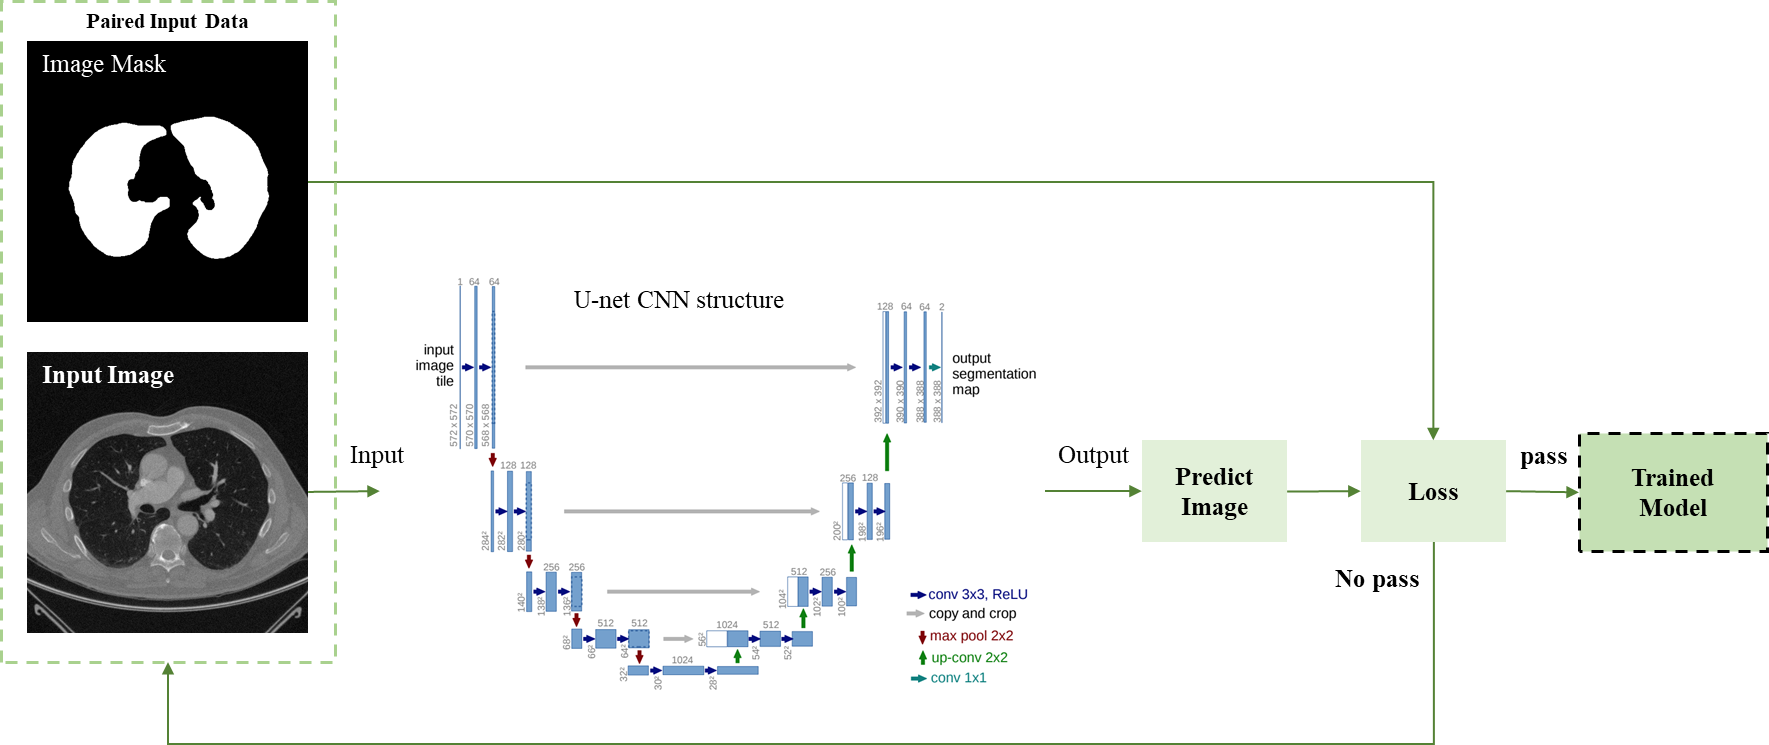

### 2️⃣模型預測

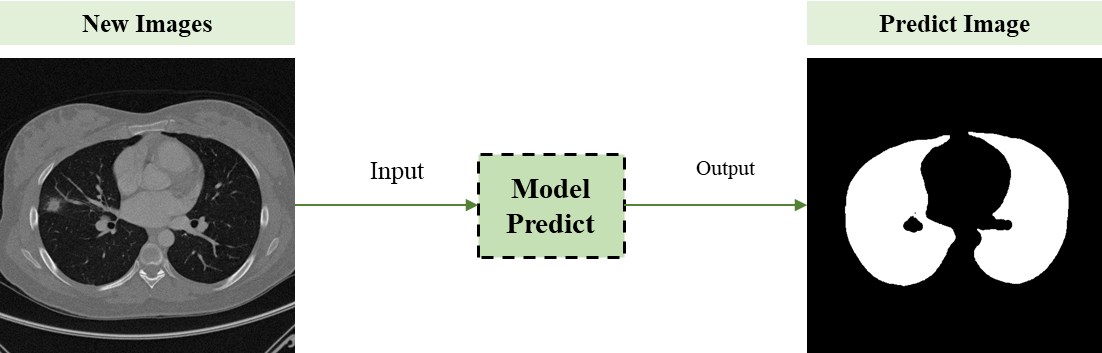

## 實作流程

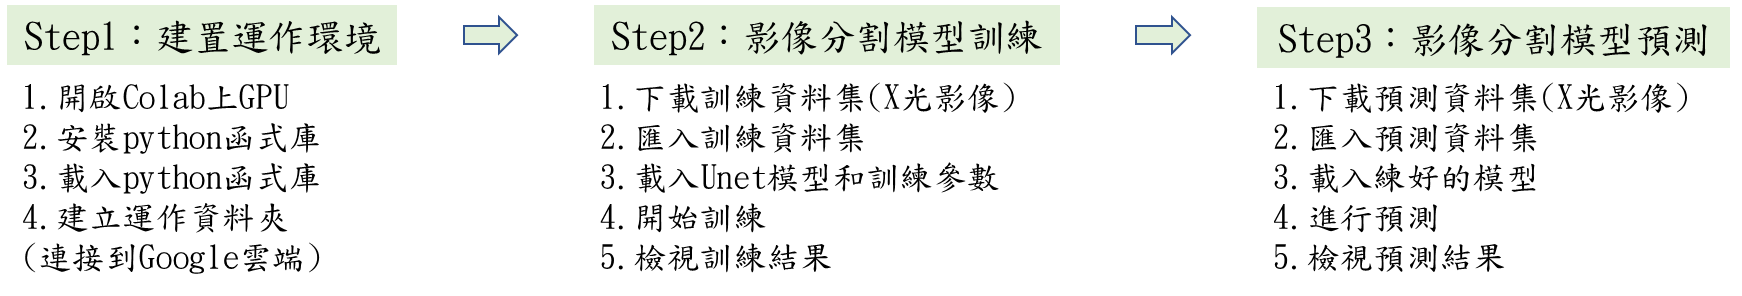

# python實作：

## 環境建置

### 1.開啟GPU的操作


1.編輯 -> 筆記本設定

2.硬體加速器 -> 點選GPU

3.儲存

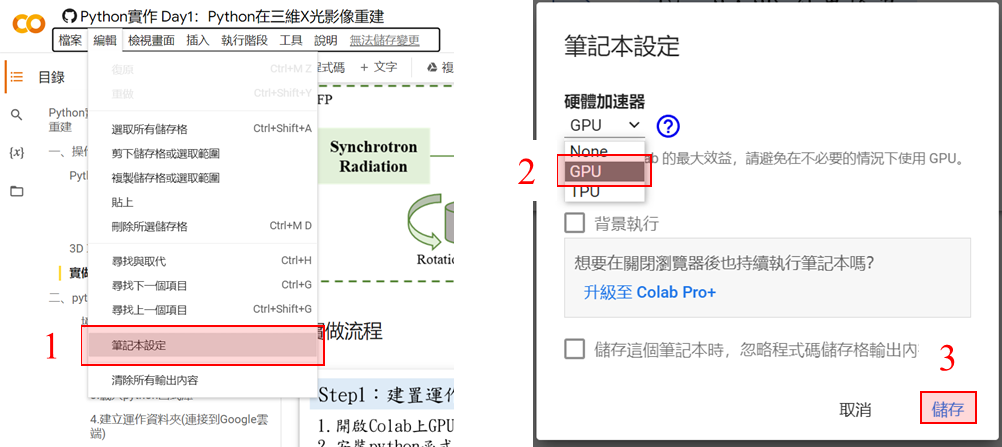

### 2.安裝python函式庫

### 3.載入python函式庫

基礎套件

In [ ]:
import numpy as np
from pathlib import Path
import gdown
import glob
import time
import os
from tqdm import tqdm

影像處理套件

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
import tifffile
import cv2

ipython互動介面

In [ ]:
%matplotlib inline
from ipywidgets import interact

深度學習套件

In [ ]:
from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Nadam
import tensorflow as tf
from keras.callbacks import ModelCheckpoint,LearningRateScheduler

### 4.建立運作資料夾(暫存區）

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1.點選'連線至 Google 雲端硬碟'

2.點選要登入的帳戶

3.點選'允許'

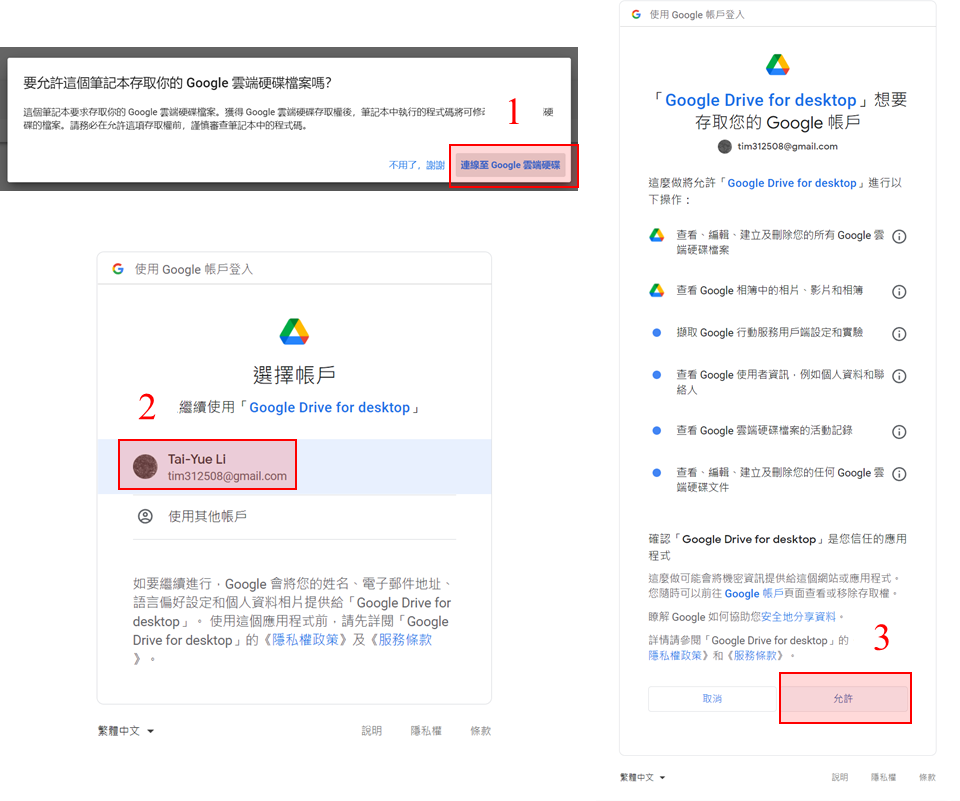

In [ ]:
project_dir = Path("day_2:segmentation")
project_dir.mkdir(exist_ok=True)

1.點選左側'檔案'

2.點選上方'重新整理'

3.可以看到創建的資料夾(day_2:segmentation)

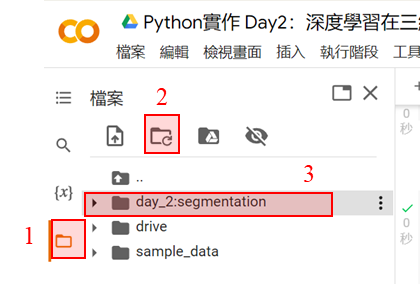

## 影像分割模型訓練（unet）

### 1.下載資料集(spleen)

In [ ]:
%cd $project_dir
url = "https://drive.google.com/uc?id=1V1j4Yq7xZFl_okHwgjLPY_fFLDCnBIDI&export=download"
output = "temp.zip"
gdown.download(url, output)
!unzip temp.zip
!rm temp.zip
url = "https://drive.google.com/uc?id=1waJ7ccimZamCLe1aVs1U8t7VzE4cMH2b&export=download"
gdown.download(url)
!mv model_unet.py '/usr/local/lib/python3.7/dist-packages'
%cd ..

/content/day_2:segmentation


Downloading...
From: https://drive.google.com/uc?id=1V1j4Yq7xZFl_okHwgjLPY_fFLDCnBIDI&export=download
To: /content/day_2:segmentation/temp.zip
100%|██████████| 100M/100M [00:01<00:00, 88.8MB/s]


Archive:  temp.zip
   creating: images/
  inflating: images/ID_0000_Z_0142.tif  
  inflating: images/ID_0001_Z_0146.tif  
  inflating: images/ID_0002_Z_0162.tif  
  inflating: images/ID_0003_Z_0132.tif  
  inflating: images/ID_0004_Z_0066.tif  
  inflating: images/ID_0005_Z_0066.tif  
  inflating: images/ID_0006_Z_0206.tif  
  inflating: images/ID_0007_Z_0211.tif  
  inflating: images/ID_0008_Z_0065.tif  
  inflating: images/ID_0009_Z_0114.tif  
  inflating: images/ID_0010_Z_0259.tif  
  inflating: images/ID_0011_Z_0156.tif  
  inflating: images/ID_0012_Z_0167.tif  
  inflating: images/ID_0013_Z_0047.tif  
  inflating: images/ID_0014_Z_0116.tif  
  inflating: images/ID_0015_Z_0136.tif  
  inflating: images/ID_0016_Z_0208.tif  
  inflating: images/ID_0017_Z_0061.tif  
  inflating: images/ID_0018_Z_0069.tif  
  inflating: images/ID_0019_Z_0088.tif  
  inflating: images/ID_0020_Z_0070.tif  
  inflating: images/ID_0021_Z_0066.tif  
  inflating: images/ID_0022_Z_0131.tif  
  inflating: imag

Downloading...
From: https://drive.google.com/uc?id=1waJ7ccimZamCLe1aVs1U8t7VzE4cMH2b&export=download
To: /content/day_2:segmentation/model_unet.py
100%|██████████| 6.08k/6.08k [00:00<00:00, 9.41MB/s]

/content


1.點選上方'重新整理'和點選'三角形符號'

2.可以看到下載的資料集在'day_2:segmentation'資料夾裡面(images為訓練影像，labels為Mask)

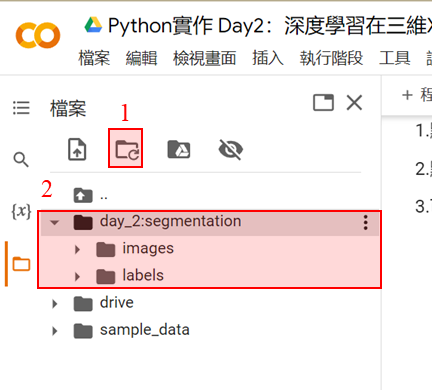

### 2.載入訓練數據集

訓練數據(images)

In [ ]:
SIZE=512
img_data1=[]
path1 = '/content/day_2:segmentation/images'
files1=sorted(os.listdir(path1))
for i in tqdm(files1):
    img1 = tifffile.imread(path1+'/'+i)
    img1=cv2.resize(img1,(SIZE, SIZE))
    img_data1.append(img_to_array(img1))

img_array1 = np.reshape(img_data1, (len(img_data1), SIZE, SIZE, 1))/255
img_array1 = img_array1.astype('float32')

100%|██████████| 267/267 [00:00<00:00, 622.26it/s]


訓練數據(labels)

In [ ]:
img_data2=[]
path2 = '/content/day_2:segmentation/labels'
files2=sorted(os.listdir(path2))
for i in tqdm(files2):
    img2 = tifffile.imread(path2+'/'+i)
    img2=cv2.resize(img2,(SIZE, SIZE))
    img_data2.append(img_to_array(img2))

img_array2 = np.reshape(img_data2, (len(img_data2), SIZE, SIZE, 1))/255
img_array2 = img_array2.astype('float32')

100%|██████████| 267/267 [00:00<00:00, 737.44it/s]


分配數據集作為訓練和驗證的比率(訓練：186個數據,驗證：81個數據)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(img_array1, img_array2, test_size = 0.30, random_state = 0)
print('x_train: ',x_train.shape)
print('x_test:  ',x_test.shape)

x_train:  (186, 512, 512, 1)
x_test:   (81, 512, 512, 1)


定義瀏覽影像的函式

In [ ]:
def browse_images(x_train,y_train):
    nf,_,_,_ = x_train.shape
    n = nf
    def view_image(layer):
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.imshow(np.reshape(x_train[layer], (SIZE, SIZE)), cmap='gray', interpolation='nearest')
        plt.subplot(122)
        plt.imshow(np.reshape(y_train[layer], (SIZE, SIZE)), cmap='gray', interpolation='nearest')
        plt.show()
        print('Total: ',nf,' frames')
    interact(view_image, layer=(0,n-1))

瀏覽訓練資料集(186張)

In [ ]:
browse_images(x_train,y_train)

interactive(children=(IntSlider(value=92, description='layer', max=185), Output()), _dom_classes=('widget-inte…

瀏覽驗證資料集(81張)

In [ ]:
browse_images(x_test,y_test)

interactive(children=(IntSlider(value=40, description='layer', max=80), Output()), _dom_classes=('widget-inter…

### 3.Unet模型影像分割訓練

載入Unet模型和模型參數

In [ ]:
from model_unet import build_unet
Nadam = tf.keras.optimizers.Nadam(learning_rate=1e-3)
img_shape=(SIZE, SIZE,1)
unet_model=build_unet(img_shape,8)
unet_model.compile(optimizer=Nadam, loss='binary_crossentropy', metrics=['accuracy'])

(None, 32, 32, 40)
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 8)  80          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                           

建立模型儲存資料夾

In [ ]:
save_model_dir = Path(project_dir/"trained_model")
save_model_dir.mkdir(exist_ok=True)

開始進行訓練

In [ ]:
bs=50
ep=50
path= str(save_model_dir)+f'/model_unet_annealer_F8_b{int(bs)}_epochs{int(ep)}.h5'
model_checkpoint = ModelCheckpoint(path,monitor='loss', verbose=1, save_best_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 1 ** x)
history = unet_model.fit(x_train, y_train, 
                    verbose=1,
                    batch_size = bs,
                    validation_data=(x_test, y_test), 
                    shuffle=True,
                    callbacks=[model_checkpoint,annealer],
                    epochs=ep)

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 0.8550 - accuracy: 0.3958
Epoch 1: loss improved from inf to 0.85504, saving model to trained_model/model_unet_annealer_F8_b10_epochs50.h5
19/19 [==============================] - 30s 436ms/step - loss: 0.8550 - accuracy: 0.3958 - val_loss: 0.5904 - val_accuracy: 0.7076 - lr: 0.0010
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.5816 - accuracy: 0.7853
Epoch 2: loss improved from 0.85504 to 0.58156, saving model to trained_model/model_unet_annealer_F8_b10_epochs50.h5
19/19 [==============================] - 5s 276ms/step - loss: 0.5816 - accuracy: 0.7853 - val_loss: 0.5766 - val_accuracy: 0.7484 - lr: 8.0000e-04
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.4320 - accuracy: 0.9621
Epoch 3: loss improved from 0.58156 to 0.43201, saving model to trained_model/model_unet_annealer_F8_b10_epochs50.h5
19/19 [==============================] - 5s 277ms/step - loss: 0.4320 - accura

顯示訓練的數據

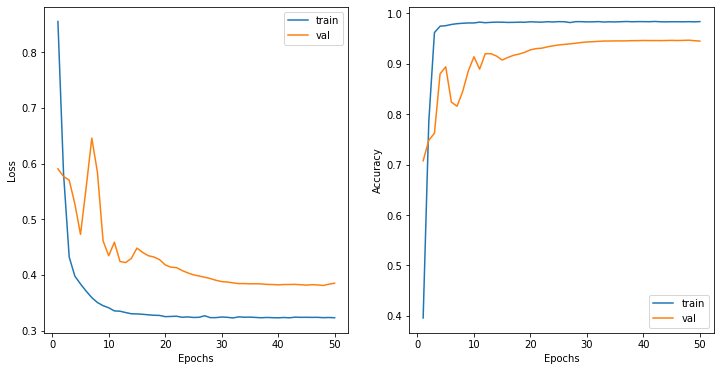

In [ ]:
loss = history.history['loss']
acc = history.history['accuracy']
v_loss = history.history['val_loss']
v_acc = history.history['val_accuracy']
epoch = range(1, ep+1)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(epoch,loss,label='train')
plt.plot(epoch,v_loss, label='val')
# plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(epoch,acc,label='train')
plt.plot(epoch,v_acc, label='val')
# plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 4.預覽模型預測結果

載入訓練好的模型(需要複製模型的檔名)

In [ ]:
from keras.models import load_model
unet_model = load_model("/content/day_2:segmentation/trained_model/model_unet_annealer_F8_b10_epochs50.h5", compile=False)

In [ ]:
# 下載預先訓練好的模型進行預測(可選)


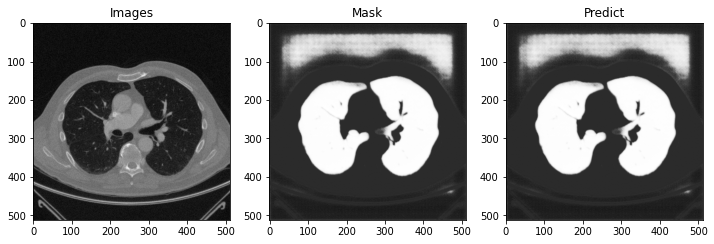

In [ ]:
img1 = tifffile.imread('/content/day_2:segmentation/images/ID_0000_Z_0142.tif')
img1=cv2.resize(img1,(SIZE, SIZE))
img_array1 = img1.astype('float32') / 255.

test_img = np.expand_dims(img_array1, axis=0)
pred = unet_model.predict(test_img)

plt.figure(figsize=(12, 6))
plt.subplot(1,3,1)
plt.imshow(test_img[0],cmap='gray')
plt.title('Images')
plt.subplot(1,3,2)
plt.imshow(pred[0].reshape(SIZE,SIZE),cmap='gray')
plt.title('Mask')
plt.subplot(1,3,3)
plt.imshow(pred[0].reshape(SIZE,SIZE),cmap='gray')
plt.title('Predict')
plt.show()

預測所有訓練數據集(總共267張)

In [ ]:
save_predict_dir = Path(project_dir/"result")
save_predict_dir.mkdir(exist_ok=True)

In [ ]:
index = 0
msg = str(project_dir)+'/images/'
imfile = sorted(glob.glob(msg+"*"+".tif"))
path= str(save_predict_dir)+'/'
print("Start Predict !!")
for i in imfile:
    # print(i,index)
    img=tifffile.imread(i)
    img=cv2.resize(img,(SIZE, SIZE))/ 255.
    img_array = img.astype('float32') 
    test_img = np.expand_dims(img_array, axis=0)
    pred = unet_model.predict(test_img)
    a=pred[0].reshape(SIZE,SIZE)*255  
    sinogram = Image.fromarray(a)
    if sinogram.mode == "F":
        sinogram = sinogram.convert('L') 
    sinogram.save(path+f'P_{str(index).zfill(5)}.tif')
    index += 1
print("Predict Done !!",len(imfile),"images")

Start Predict !!
Predict Done !! 267 images


匯入所有訓練數據預測的結果

In [ ]:
predict_train_data=[]
path = str(save_predict_dir)
files=sorted(os.listdir(path))
for i in tqdm(files):
    img = tifffile.imread(path+'/'+i)
    img=cv2.resize(img,(SIZE, SIZE))
    predict_train_data.append(img_to_array(img))

predict_train_data = np.reshape(predict_train_data, (len(predict_train_data), SIZE, SIZE, 1))/255
predict_train_data = predict_train_data.astype('float32')

100%|██████████| 267/267 [00:00<00:00, 1330.01it/s]


瀏覽所有訓練數據預測的結果

In [ ]:
nf,_,_,_ = x_train.shape
def browse_images(x_train,y_train,p_train):
    n = nf
    def view_image(layer):
        plt.figure(figsize=(12, 6))
        plt.subplot(131)
        plt.imshow(np.reshape(x_train[layer], (SIZE, SIZE)), cmap='gray', interpolation='nearest')
        plt.subplot(132)
        plt.imshow(np.reshape(y_train[layer], (SIZE, SIZE)), cmap='gray', interpolation='nearest')
        plt.subplot(133)
        plt.imshow(np.reshape(p_train[layer], (SIZE, SIZE)), cmap='gray', interpolation='nearest')
        plt.show()
    interact(view_image, layer=(0,n-1))
browse_images(img_data1, img_data2,predict_train_data)

interactive(children=(IntSlider(value=92, description='layer', max=185), Output()), _dom_classes=('widget-inte…